<a href="https://colab.research.google.com/github/konan0802/100knock-data-analytics/blob/main/6%E7%AB%A0_%E7%89%A9%E6%B5%81%E3%81%AE%E6%9C%80%E9%81%A9%E3%83%AB%E3%83%BC%E3%83%88%E3%82%92%E3%82%B3%E3%83%B3%E3%82%B5%E3%83%AB%E3%83%86%E3%82%A3%E3%83%B3%E3%82%AF%E3%82%99%E3%81%99%E3%82%8B%EF%BC%91%EF%BC%90%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os
os.chdir('/content/drive/MyDrive/100knock-data_analytics/6章') #ここを変更。

# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [ ]:
import pandas as pd

factories = pd.read_csv("tbl_factory.csv", index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [ ]:
warehouses = pd.read_csv("tbl_warehouse.csv", index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [ ]:
cost = pd.read_csv("rel_cost.csv", index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [ ]:
trans = pd.read_csv("tbl_transaction.csv", index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [ ]:
join_data = pd.merge(trans, cost, left_on=["ToFC", "FromWH"], right_on=["FCID", "WHID"], how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [ ]:
join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [ ]:
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北,山形倉庫,65,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北,郡山倉庫,60,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東,品川倉庫,41,関東


In [ ]:
join_data = join_data[["TransactionDate", "Quantity", "Cost", "ToFC", "FCName", "FCDemand", "FromWH", "WHName", "WHSupply", "WHRegion"]]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [ ]:
kanto = join_data.loc[join_data["WHRegion"]=="関東"]
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [ ]:
tohoku = join_data.loc[join_data["WHRegion"]=="東北"]
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [ ]:
print("関東支社の総コスト：", str(kanto["Cost"].sum()), "万円")
print("東北支社の総コスト：", str(tohoku["Cost"].sum()), "万円")

関東支社の総コスト： 2189.3 万円
東北支社の総コスト： 2062.0 万円


In [ ]:
print("関東支社の総部品輸送個数：", str(kanto["Quantity"].sum()), "個")
print("東北支社の総部品輸送個数：", str(tohoku["Quantity"].sum()), "個")

関東支社の総部品輸送個数： 49146 個
東北支社の総部品輸送個数： 50214 個


In [ ]:
tmp = (kanto["Cost"].sum() / kanto["Quantity"].sum()) * 10000
print("関東支社の部品１つ当たりの輸送コスト：", str(tmp), "円")
tmp = (tohoku["Cost"].sum() / tohoku["Quantity"].sum()) * 10000
print("東北支社の部品１つ当たりの輸送コスト：", str(tmp), "円")

関東支社の部品１つ当たりの輸送コスト： 445.46860375208564 円
東北支社の部品１つ当たりの輸送コスト： 410.6424503126618 円


In [ ]:
cost_chk = pd.merge(cost, factories, on="FCID", how="left")
print("東京支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="関東"].mean()) + "万円")
print("東北支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="東北"].mean()) + "万円")

東京支社の平均輸送コスト：1.075万円
東北支社の平均輸送コスト：1.05万円


### ノック５３：ネットワークを可視化してみよう

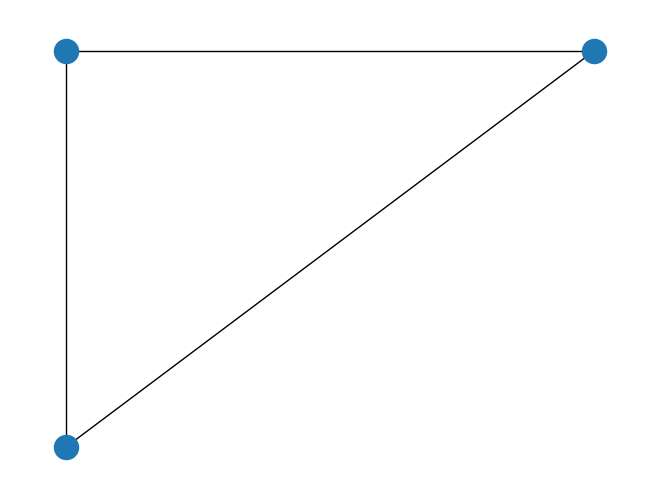

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

# 辺の設定
G.add_edge("nodeA", "nodeB")
G.add_edge("nodeA", "nodeC")
G.add_edge("nodeB", "nodeC")

# 座標の設定
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)

# 描画
nx.draw(G, pos)

# 表示
plt.show()

### ノック５４：ネットワークにノードを追加してみよう

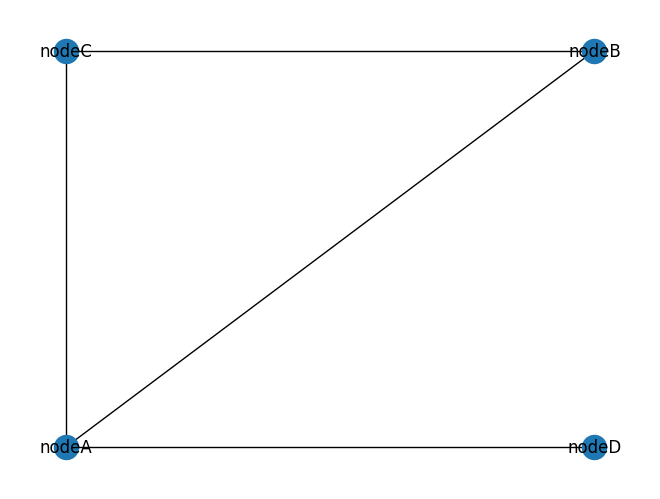

In [ ]:
G.add_node("nodeD")
G.add_edge("nodeA", "nodeD")
pos["nodeD"]=(1,0)
nx.draw(G, pos, with_labels=True)
plt.show()

### ノック５５：ルートの重みづけを実施しよう

<ipython-input-45-9367a6f9f881>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weiths.append(df_w.iloc[i][j]*size)


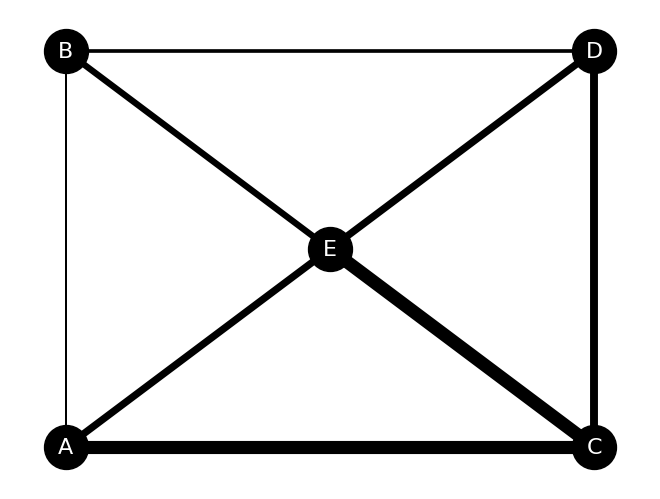

In [ ]:
import numpy as np

# データ読み込み
df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 辺の設定＆エッジの重みのリスト化
size = 10
edge_weiths = []
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        if not (i==j):
          # 辺の追加
          G.add_edge(df_w.columns[i], df_w.columns[j])
          # エッジの重みの追加
          edge_weiths.append(df_w.iloc[i][j]*size)

# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0], df_p[node][1])

# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color = 'k', font_color = 'w', width=edge_weiths)

# 表示
plt.show()


### ノック５６：輸送ルート情報を読み込んでみよう

In [ ]:
df_tr = pd.read_csv('trans_route.csv', index_col="工場")
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

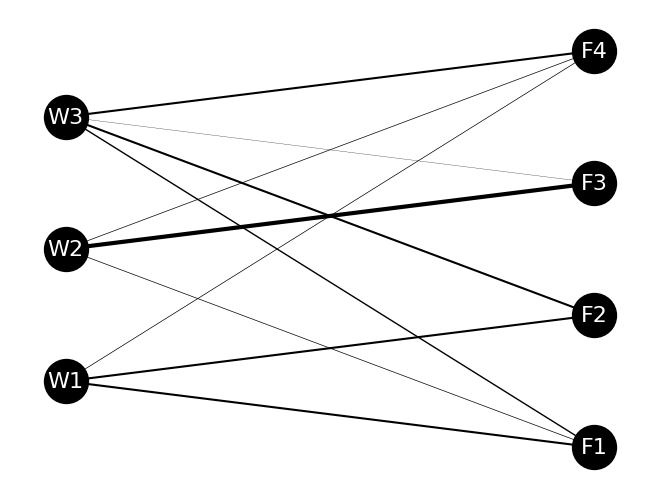

In [ ]:
# データ読み込み
df_tr = pd.read_csv('trans_route.csv', index_col="工場")
df_pos = pd.read_csv('trans_route_pos.csv')

# グラフオブジェクトの作成
G = nx.Graph()

for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定＆エッジの重みのリスト化
num_pre = 0
edge_weiths = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
          # 辺の追加
          G.add_edge(df_pos.columns[i], df_pos.columns[j])
          # エッジの重みの追加
          if num_pre < len(G.edges):
            num_pre = len(G.edges)
            weight = 0
            if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
              if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                weight = df_te[df_pos.columns[i]][df_pos.columns[j]]*size
            elif(df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
              if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
            edge_weiths.append(weight)

# 座標の設定
post = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0], df_pos[node][1])

# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color = 'k', font_color = 'w', width=edge_weiths)

# 表示
plt.show()

### ノック５８：輸送コスト関数を作成しよう

In [ ]:
# データ読み込み
df_tr = pd.read_csv('trans_route.csv', index_col="工場")
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")

# 輸送コスト関数
def trans_cost(df_tr, df_tc):
  const = 0
  for i in range(len(df_tc.index)):
    for j in range(len(df_tr.columns)):
      const += df_tr.iloc[i][j]*df_tc.iloc[i][j]
  return const

print("輸送コスト：" + str(trans_cost(df_tr, df_tc)))

輸送コスト：1493


<ipython-input-53-3bed93ec87d7>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  const += df_tr.iloc[i][j]*df_tc.iloc[i][j]


### ノック５９：制約条件を作ってみよう

In [ ]:
# データ読み込み
df_tr = pd.read_csv('trans_route.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 需要側の制約条件
for i in range(len(df_demand.columns)):
  temp_sum = sum(df_tr[df_demand.columns[i]])
  print(str(df_demand.columns[i])+"への輸送量："+str(temp_sum)+"（需要量："+str(df_demand.iloc[0][i])+"）")
  if temp_sum >= df_demand.iloc[0][i]:
    print("需要量を満たしています。")
  else:
    print("需要量を満たしていません。輸送ルートを再計算して下さい。")

# 供給側の制約条件
for i in range(len(df_supply.columns)):
  temp_sum = sum(df_tr.loc[df_supply.columns[i]])
  print(str(df_supply.columns[i])+"からの輸送量："+str(temp_sum)+"（供給限界："+str(df_supply.iloc[0][i])+"）")
  if temp_sum <= df_supply.iloc[0][i]:
    print("供給限界を満たしています。")
  else:
    print("供給限界を超過しています。輸送ルートを再計算して下さい。")

F1への輸送量：30（需要量：28）
需要量を満たしています。
F2への輸送量：30（需要量：29）
需要量を満たしています。
F3への輸送量：32（需要量：31）
需要量を満たしています。
F4への輸送量：25（需要量：25）
需要量を満たしています。
W1からの輸送量：35（供給限界：35）
供給限界を満たしています。
W2からの輸送量：40（供給限界：41）
供給限界を満たしています。
W3からの輸送量：42（供給限界：42）
供給限界を満たしています。


<ipython-input-58-20281ee3dc73>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(df_demand.columns[i])+"への輸送量："+str(temp_sum)+"（需要量："+str(df_demand.iloc[0][i])+"）")
<ipython-input-58-20281ee3dc73>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_sum >= df_demand.iloc[0][i]:
<ipython-input-58-20281ee3dc73>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(df_supply.columns[i])+"からの輸送量："+str(temp_sum)+"（供給

### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう

In [61]:
# データ読み込み
df_tr_new = pd.read_csv('trans_route_new.csv', index_col="工場")
print(df_tr_new)

# 総輸送コスト再計算
print("輸送コスト（変更後）：" + str(trans_cost(df_tr_new, df_tc)))

# 制約条件計算関数
# 需要側
def condition_demand(df_tr, df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if temp_sum >= df_demand.iloc[0][i]:
      flag[i] = 1
  return flag

def condition_supply(df_tr, df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

print("需要条件計算結果："+str(condition_demand(df_tr_new, df_demand)))
print("供給条件計算結果："+str(condition_supply(df_tr_new, df_supply)))

    F1  F2  F3  F4
工場                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
輸送コスト（変更後）：1428
需要条件計算結果：[1. 1. 1. 1.]
供給条件計算結果：[1. 0. 1.]


<ipython-input-53-3bed93ec87d7>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  const += df_tr.iloc[i][j]*df_tc.iloc[i][j]
<ipython-input-61-42e52fdc3cca>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_sum >= df_demand.iloc[0][i]:
<ipython-input-61-42e52fdc3cca>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_sum <= df_supply.iloc[0][i]:
